## 1. LIBRARY IMPORTS

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import pickle
import time

print("✓ Libraries imported")
print(f"LightGBM version: {lgb.__version__}")

✓ Libraries imported
LightGBM version: 4.6.0


## 2. DATA LOADING - ALL APPLIANCES

Loading data for ALL appliances to create a multi-output prediction model.

In [35]:
# ===== CONFIGURATION =====
# Load ALL appliances for multi-output prediction

# Base data path
DATA_BASE_PATH = os.path.join("..", "data", "processed", "15min", "model_ready")

# List of available appliances
available_appliances = [d for d in os.listdir(DATA_BASE_PATH) 
                        if os.path.isdir(os.path.join(DATA_BASE_PATH, d))]
print(f"Available appliances: {available_appliances}")
print(f"Total appliances: {len(available_appliances)}\n")

# Load input data (X) from first appliance (all appliances share same input)
first_appliance = available_appliances[0]
APPLIANCE_PATH = os.path.join(DATA_BASE_PATH, first_appliance)

X_train = np.load(os.path.join(APPLIANCE_PATH, "X_train.npy"))
X_val = np.load(os.path.join(APPLIANCE_PATH, "X_val.npy"))
X_test = np.load(os.path.join(APPLIANCE_PATH, "X_test.npy"))

print(f"Input data loaded from: {first_appliance}")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Load target data (y) for ALL appliances
y_train_dict = {}
y_val_dict = {}
y_test_dict = {}

print(f"\n📦 Loading targets for all appliances...")
for appliance in available_appliances:
    appliance_path = os.path.join(DATA_BASE_PATH, appliance)
    
    y_train_dict[appliance] = np.load(os.path.join(appliance_path, "y_train.npy"))
    y_val_dict[appliance] = np.load(os.path.join(appliance_path, "y_val.npy"))
    y_test_dict[appliance] = np.load(os.path.join(appliance_path, "y_test.npy"))
    
    print(f"  ✓ {appliance}: {y_train_dict[appliance].shape}")

# Stack all appliances into a single multi-output target
# Shape: (samples, seq_len, num_appliances)
y_train = np.stack([y_train_dict[app] for app in available_appliances], axis=-1).squeeze(2)
y_val = np.stack([y_val_dict[app] for app in available_appliances], axis=-1).squeeze(2)
y_test = np.stack([y_test_dict[app] for app in available_appliances], axis=-1).squeeze(2)

print(f"\n✓ Multi-output targets created:")
print(f"  y_train: {y_train.shape} (samples, seq_len, appliances)")
print(f"  y_val:   {y_val.shape}")
print(f"  y_test:  {y_test.shape}")

# ===== DATA CLEANING: THRESHOLD FOR NEAR-ZERO VALUES =====
ZERO_THRESHOLD = 0.001  # Values below this threshold become 0

# Count values before cleaning
before_train = np.sum((y_train > 0) & (y_train < ZERO_THRESHOLD))
before_val = np.sum((y_val > 0) & (y_val < ZERO_THRESHOLD))
before_test = np.sum((y_test > 0) & (y_test < ZERO_THRESHOLD))

# Apply threshold to targets (y)
y_train = np.where(y_train < ZERO_THRESHOLD, 0.0, y_train)
y_val = np.where(y_val < ZERO_THRESHOLD, 0.0, y_val)
y_test = np.where(y_test < ZERO_THRESHOLD, 0.0, y_test)

print(f"🧹 Cleaning near-zero values (threshold={ZERO_THRESHOLD}):")
print(f"   Train: {before_train:,} values → 0")
print(f"   Val:   {before_val:,} values → 0")
print(f"   Test:  {before_test:,} values → 0")

# Load scaler if available
scaler_path = os.path.join(DATA_BASE_PATH, "scaler.pkl")
if os.path.exists(scaler_path):
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    print(f"✓ Scaler loaded from {scaler_path}")
else:
    scaler = None
    print("⚠️ Scaler not found, data might already be normalized")

print(f"\n✓ Multi-appliance dataset loaded:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape} | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape} | y_test:  {y_test.shape}")

# Determine parameters from data
# X shape: (samples, seq_len, num_features)
# y shape: (samples, seq_len, num_appliances)
window_size = X_train.shape[1]  # 99 timesteps
num_input_features = X_train.shape[2]  # 7 features
num_appliances = y_train.shape[2]  # All appliances

print(f"\n✓ Window size: {window_size} timesteps")
print(f"✓ Input features: {num_input_features}")
print(f"✓ Target appliances: {num_appliances}")
print(f"✓ Appliances: {', '.join(available_appliances)}")

Available appliances: ['chargingstation_socket', 'dishwasher', 'dryer', 'garagecabinet', 'heatpump', 'heatpump_controller', 'oven', 'rainwaterpump', 'rangehood', 'smappeecharger', 'stove', 'washingmachine']
Total appliances: 12

Input data loaded from: chargingstation_socket
  X_train: (24097, 96, 7)
  X_val:   (5377, 96, 7)
  X_test:  (5281, 96, 7)

📦 Loading targets for all appliances...
  ✓ chargingstation_socket: (24097, 96, 1)
  ✓ dishwasher: (24097, 96, 1)
  ✓ dryer: (24097, 96, 1)
  ✓ garagecabinet: (24097, 96, 1)
  ✓ heatpump: (24097, 96, 1)
  ✓ heatpump_controller: (24097, 96, 1)
  ✓ oven: (24097, 96, 1)
  ✓ rainwaterpump: (24097, 96, 1)
  ✓ rangehood: (24097, 96, 1)
  ✓ smappeecharger: (24097, 96, 1)
  ✓ stove: (24097, 96, 1)
  ✓ washingmachine: (24097, 96, 1)

✓ Multi-output targets created:
  y_train: (24097, 96, 12) (samples, seq_len, appliances)
  y_val:   (5377, 96, 12)
  y_test:  (5281, 96, 12)
🧹 Cleaning near-zero values (threshold=0.001):
   Train: 6,145,611 values → 

## 3. EXPLORATORY DATA ANALYSIS

In [36]:
# Analyze loaded data
print("=== DATASET STATISTICS ===")
print(f"\n📊 Input (X) - {num_input_features} features:")
print(f"  Train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"  Val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"  Test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\n📊 Target (y - ALL APPLIANCES):")
print(f"  Train: min={y_train.min():.4f}, max={y_train.max():.4f}, mean={y_train.mean():.4f}")
print(f"  Val:   min={y_val.min():.4f}, max={y_val.max():.4f}, mean={y_val.mean():.4f}")
print(f"  Test:  min={y_test.min():.4f}, max={y_test.max():.4f}, mean={y_test.mean():.4f}")

print(f"\n📊 Statistics per appliance (y_train):")
for i, appliance in enumerate(available_appliances):
    app_data = y_train[:, :, i]
    print(f"  {appliance}: min={app_data.min():.4f}, max={app_data.max():.4f}, mean={app_data.mean():.4f}")

print(f"\n📊 Dimensions:")
print(f"  Total sequences: {len(X_train) + len(X_val) + len(X_test)}")
print(f"  Train: {len(X_train)} ({len(X_train)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Val:   {len(X_val)} ({len(X_val)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")
print(f"  Test:  {len(X_test)} ({len(X_test)/(len(X_train)+len(X_val)+len(X_test))*100:.1f}%)")

=== DATASET STATISTICS ===

📊 Input (X) - 7 features:
  Train: min=0.0000, max=1.0000, mean=0.4376
  Val:   min=0.0000, max=1.0000, mean=0.4454
  Test:  min=0.0000, max=1.0000, mean=0.4467

📊 Target (y - ALL APPLIANCES):
  Train: min=0.0000, max=1.0000, mean=0.0444
  Val:   min=0.0000, max=0.9945, mean=0.0538
  Test:  min=0.0000, max=1.2496, mean=0.0528

📊 Statistics per appliance (y_train):
  chargingstation_socket: min=0.0000, max=1.0000, mean=0.0235
  dishwasher: min=0.0000, max=1.0000, mean=0.0153
  dryer: min=0.0000, max=1.0000, mean=0.0008
  garagecabinet: min=0.0000, max=1.0000, mean=0.1338
  heatpump: min=0.0000, max=1.0000, mean=0.1147
  heatpump_controller: min=0.0000, max=1.0000, mean=0.1788
  oven: min=0.0000, max=1.0000, mean=0.0099
  rainwaterpump: min=0.0000, max=1.0000, mean=0.0004
  rangehood: min=0.0000, max=1.0000, mean=0.0101
  smappeecharger: min=0.0000, max=1.0000, mean=0.0217
  stove: min=0.0000, max=1.0000, mean=0.0039
  washingmachine: min=0.0000, max=1.0000, m

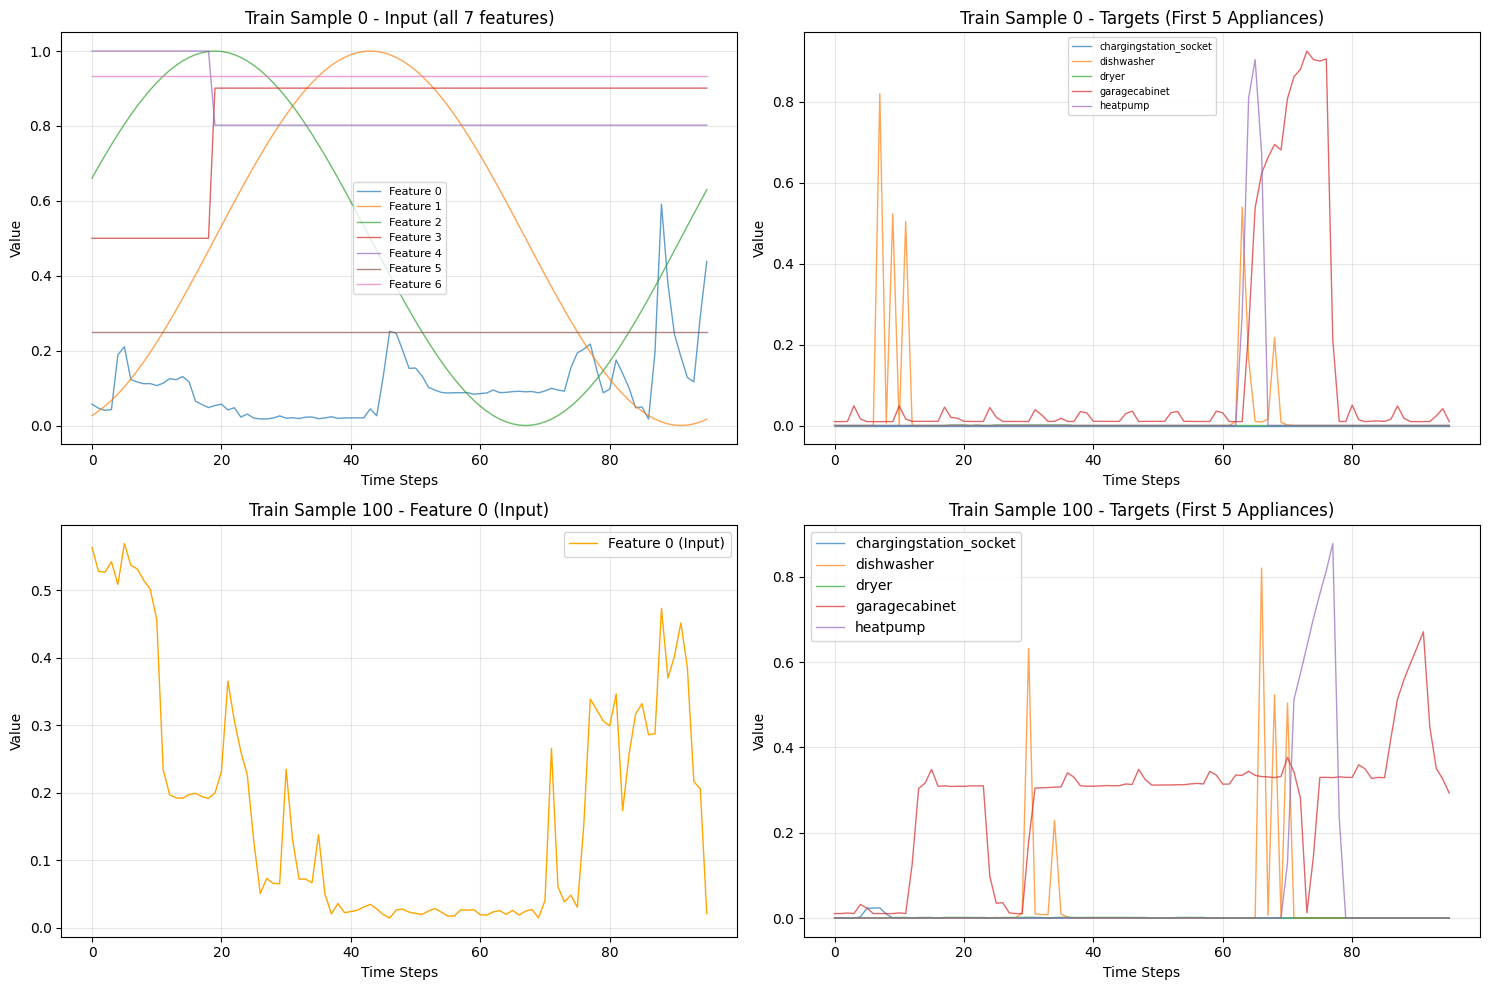

In [37]:
# Visualize some example sequences
sample_idx = 0

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot all input features for first sample
ax = axes[0, 0]
for i in range(num_input_features):
    ax.plot(X_train[sample_idx, :, i], linewidth=1, label=f'Feature {i}', alpha=0.7)
ax.set_title(f'Train Sample {sample_idx} - Input (all {num_input_features} features)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Target for first sample - show all appliances
ax = axes[0, 1]
for i, appliance in enumerate(available_appliances[:5]):  # Show first 5 for readability
    ax.plot(y_train[sample_idx, :, i], linewidth=1, alpha=0.7, label=appliance)
ax.set_title(f'Train Sample {sample_idx} - Targets (First 5 Appliances)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=7)

# Second sequence - only feature 0 (assuming it's the main aggregate)
sample_idx_2 = min(100, len(X_train)-1)
ax = axes[1, 0]
ax.plot(X_train[sample_idx_2, :, 0], linewidth=1, color='orange', label='Feature 0 (Input)')
ax.set_title(f'Train Sample {sample_idx_2} - Feature 0 (Input)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1, 1]
for i, appliance in enumerate(available_appliances[:5]):  # Show first 5 for readability
    ax.plot(y_train[sample_idx_2, :, i], linewidth=1, alpha=0.7, label=appliance)
ax.set_title(f'Train Sample {sample_idx_2} - Targets (First 5 Appliances)')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. DATA PREPARATION FOR LGBM

LightGBM requires flattened data, so we need to reshape from (samples, seq_len, features) to 2D format.

In [38]:
# ===== RESHAPE DATA FOR LGBM =====
# LightGBM expects 2D input: (samples, features)
# We have: (samples, seq_len, num_features)
# Strategy: Flatten each sequence into a single feature vector

print("🔄 Reshaping data for LightGBM...")

# Flatten input sequences: (samples, seq_len, features) -> (samples, seq_len * features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Flatten target sequences: (samples, seq_len, num_appliances) -> (samples, seq_len * num_appliances)
y_train_flat = y_train.reshape(y_train.shape[0], -1)
y_val_flat = y_val.reshape(y_val.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)

print(f"✓ Reshaped data:")
print(f"  X_train: {X_train.shape} -> {X_train_flat.shape}")
print(f"  X_val:   {X_val.shape} -> {X_val_flat.shape}")
print(f"  X_test:  {X_test.shape} -> {X_test_flat.shape}")
print(f"  y_train: {y_train.shape} -> {y_train_flat.shape} (timesteps × appliances)")
print(f"  y_val:   {y_val.shape} -> {y_val_flat.shape}")
print(f"  y_test:  {y_test.shape} -> {y_test_flat.shape}")

🔄 Reshaping data for LightGBM...
✓ Reshaped data:
  X_train: (24097, 96, 7) -> (24097, 672)
  X_val:   (5377, 96, 7) -> (5377, 672)
  X_test:  (5281, 96, 7) -> (5281, 672)
  y_train: (24097, 96, 12) -> (24097, 1152) (timesteps × appliances)
  y_val:   (5377, 96, 12) -> (5377, 1152)
  y_test:  (5281, 96, 12) -> (5281, 1152)


## 5. MODEL TRAINING WITH LGBM

Training LightGBM with multi-output regression (one model per timestep output).

In [39]:
# ===== LGBM CONFIGURATION =====
lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 10,
    'min_child_samples': 20,
    'reg_alpha': 0.1,  # L1 regularization
    'reg_lambda': 0.1,  # L2 regularization
}

num_boost_round = 500
early_stopping_rounds = 50

print("📋 LightGBM Configuration:")
for key, value in lgbm_params.items():
    print(f"   {key}: {value}")
print(f"   num_boost_round: {num_boost_round}")
print(f"   early_stopping_rounds: {early_stopping_rounds}")

📋 LightGBM Configuration:
   objective: regression
   metric: rmse
   boosting_type: gbdt
   num_leaves: 31
   learning_rate: 0.05
   feature_fraction: 0.8
   bagging_fraction: 0.8
   bagging_freq: 5
   verbose: -1
   max_depth: 10
   min_child_samples: 20
   reg_alpha: 0.1
   reg_lambda: 0.1
   num_boost_round: 500
   early_stopping_rounds: 50


In [ ]:
# ===== TRAIN LGBM MODELS =====
# Strategy: Train one model per output (timestep × appliance combination)
# Total outputs = seq_len × num_appliances

num_outputs = y_train_flat.shape[1]  # timesteps * num_appliances
num_timesteps_per_appliance = window_size

print(f"\n🚀 Training {num_outputs} LightGBM models...")
print(f"   = {window_size} timesteps × {num_appliances} appliances")
print(f"   = {num_outputs // num_appliances} outputs per appliance\n")

models = []
train_rmses = []
val_rmses = []

start_time = time.time()

for t in range(y_train_flat.shape[1]):
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train_flat, label=y_train_flat[:, t])
    val_data = lgb.Dataset(X_val_flat, label=y_val_flat[:, t], reference=train_data)
    
    # Train model
    model = lgb.train(
        lgbm_params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)]
    )
    
    models.append(model)
    
    # Calculate RMSE for this model
    train_pred = model.predict(X_train_flat)
    val_pred = model.predict(X_val_flat)
    train_rmse = np.sqrt(mean_squared_error(y_train_flat[:, t], train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_flat[:, t], val_pred))
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    
    # Progress update every 50 outputs (to avoid too much printing)
    if (t + 1) % 50 == 0 or t == 0:
        appliance_idx = (t // window_size)
        timestep_idx = (t % window_size)
        current_appliance = available_appliances[appliance_idx] if appliance_idx < len(available_appliances) else "?"
        print(f"Output {t+1:4d}/{y_train_flat.shape[1]} ({current_appliance}, T{timestep_idx}) | Train RMSE: {train_rmses[-1]:.6f} | Val RMSE: {val_rmses[-1]:.6f} | Iter: {model.best_iteration}")

print(f"✓ Average Val RMSE: {np.mean(val_rmses):.6f}")

training_time = time.time() - start_timeprint(f"✓ Average Train RMSE: {np.mean(train_rmses):.6f}")

print(f"\n✓ Training completed in {training_time/60:.1f} minutes")

print(f"✓ Average Val RMSE: {np.mean(val_rmses):.6f}")

print(f"✓ Average Train RMSE: {np.mean(train_rmses):.6f}")training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time/60:.1f} minutes")


🚀 Training 1152 LightGBM models...
   = 96 timesteps × 12 appliances
   = 96 outputs per appliance



IndexError: list index out of range

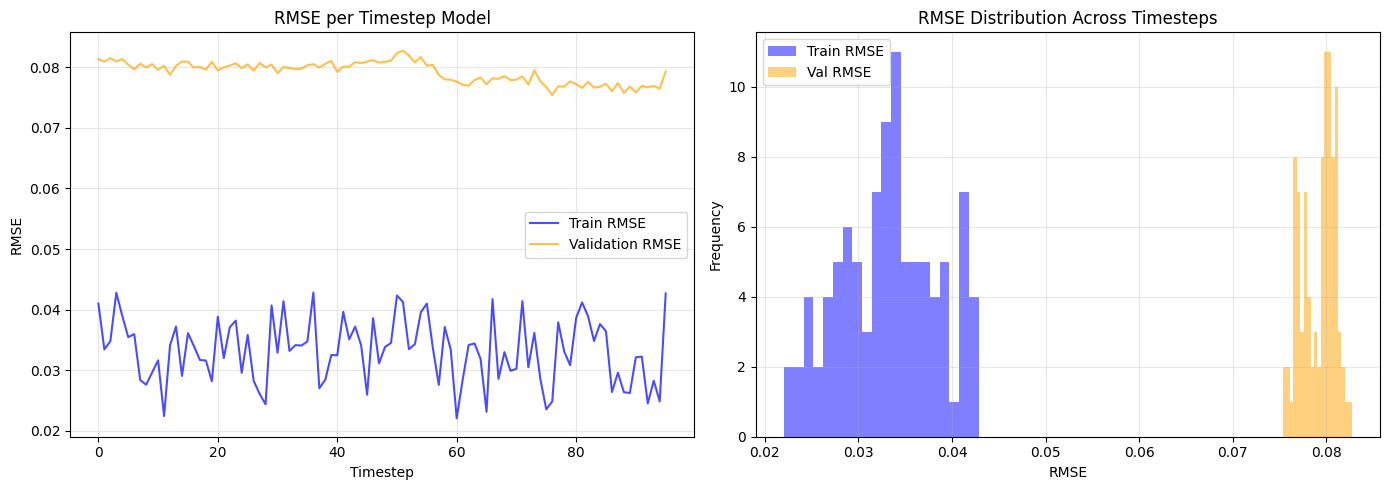

In [ ]:
# ===== VISUALIZE TRAINING METRICS =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot RMSE per timestep
ax = axes[0]
ax.plot(train_rmses, label='Train RMSE', color='blue', alpha=0.7)
ax.plot(val_rmses, label='Validation RMSE', color='orange', alpha=0.7)
ax.set_xlabel('Timestep')
ax.set_ylabel('RMSE')
ax.set_title('RMSE per Timestep Model')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot RMSE distribution
ax = axes[1]
ax.hist(train_rmses, bins=20, alpha=0.5, label='Train RMSE', color='blue')
ax.hist(val_rmses, bins=20, alpha=0.5, label='Val RMSE', color='orange')
ax.set_xlabel('RMSE')
ax.set_ylabel('Frequency')
ax.set_title('RMSE Distribution Across Timesteps')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. INFERENCE & PREDICTIONS

In [ ]:
# ===== MAKE PREDICTIONS =====
def predict_sequence(models, X_flat):
    """Predict full sequence using multiple LGBM models"""
    predictions = []
    for model in models:
        pred = model.predict(X_flat)
        predictions.append(pred)
    return np.array(predictions).T  # Shape: (samples, timesteps)

print("🔮 Generating predictions...")

# Predict on all sets
y_train_pred = predict_sequence(models, X_train_flat)
y_val_pred = predict_sequence(models, X_val_flat)
y_test_pred = predict_sequence(models, X_test_flat)

# Apply zero threshold (no negative predictions)
y_train_pred = np.maximum(y_train_pred, 0)
y_val_pred = np.maximum(y_val_pred, 0)
y_test_pred = np.maximum(y_test_pred, 0)

print(f"✓ Predictions generated:")
print(f"  Train: {y_train_pred.shape}")
print(f"  Val:   {y_val_pred.shape}")
print(f"  Test:  {y_test_pred.shape}")

🔮 Generating predictions...
✓ Predictions generated:
  Train: (24097, 96)
  Val:   (5377, 96)
  Test:  (5281, 96)


## 7. EVALUATION ON TEST SET

In [ ]:
# ===== EVALUATE SINGLE SAMPLE - ALL APPLIANCES =====
test_idx = 0

print(f"📊 TEST Metrics (sequence {test_idx}) - PER APPLIANCE:\n")

for appliance_idx, appliance in enumerate(available_appliances):
    # Extract predictions and actuals for this appliance
    start_col = appliance_idx * window_size
    end_col = (appliance_idx + 1) * window_size
    
    pred = y_test_pred[test_idx, start_col:end_col]
    actual = y_test_flat[test_idx, start_col:end_col]
    
    # Calculate metrics
    mse = mean_squared_error(actual, pred)
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    
    print(f"  {appliance:<25} | MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.4f}")

📊 TEST Metrics (sequence 0):
  MSE: 0.000130
  MAE: 0.004837
  R²:  0.0000


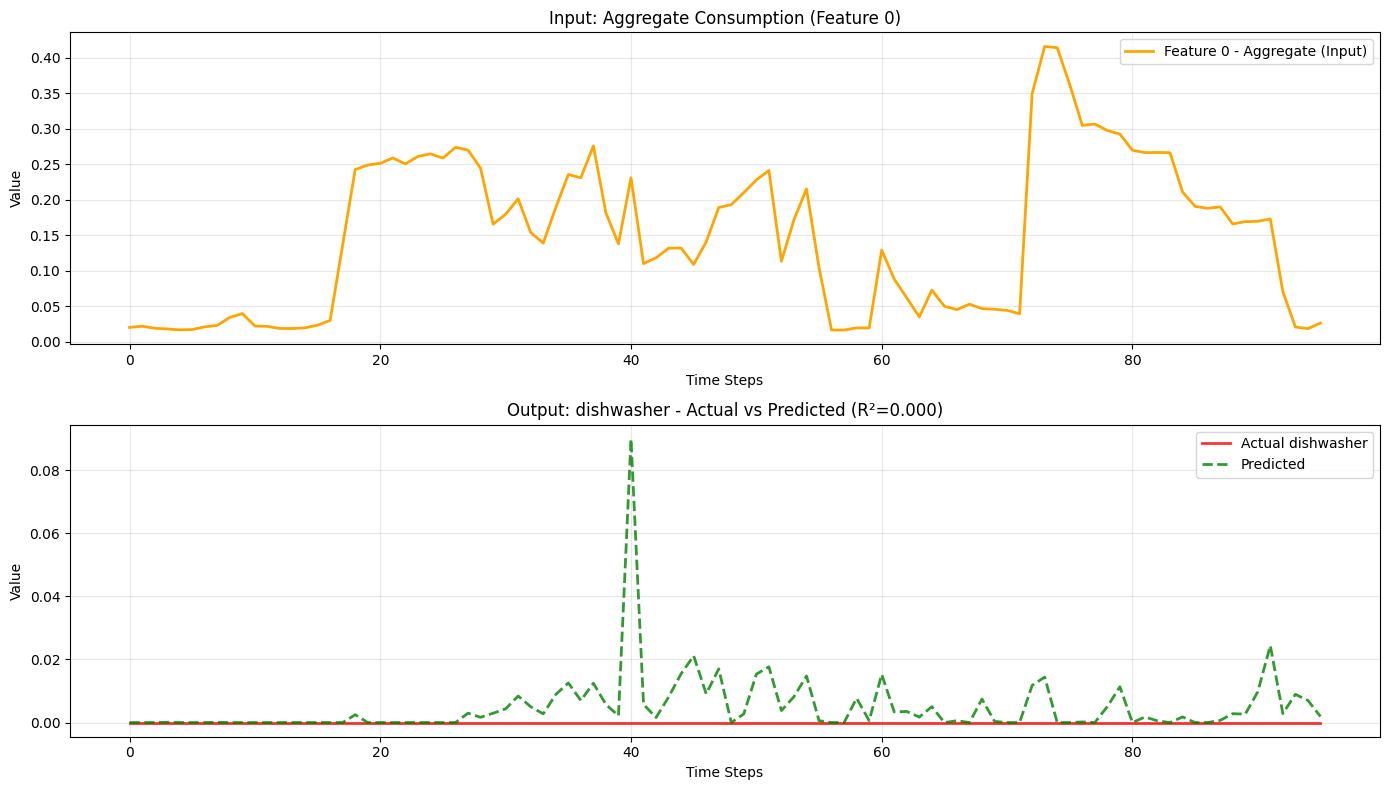

In [ ]:
# ===== VISUALIZE PREDICTIONS - SHOW MULTIPLE APPLIANCES =====
test_idx_vis = 0
num_appliances_to_show = min(4, num_appliances)  # Show up to 4 appliances

fig, axes = plt.subplots(num_appliances_to_show + 1, 1, figsize=(14, 4 * (num_appliances_to_show + 1)))

# Input - show Feature 0 (assuming it's aggregate)
input_data = X_test[test_idx_vis, :, 0]
axes[0].plot(input_data, color='orange', label='Feature 0 - Aggregate (Input)', linewidth=2)
axes[0].set_title('Input: Aggregate Consumption (Feature 0)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output: Prediction vs Actual for each appliance
for i in range(num_appliances_to_show):
    appliance = available_appliances[i]
    start_col = i * window_size
    end_col = (i + 1) * window_size
    
    pred = y_test_pred[test_idx_vis, start_col:end_col]
    actual = y_test_flat[test_idx_vis, start_col:end_col]
    r2 = r2_score(actual, pred)
    
    axes[i+1].plot(actual, color='red', label=f'Actual {appliance}', alpha=0.8, linewidth=2)
    axes[i+1].plot(pred, color='green', linestyle='--', label='Predicted (LGBM)', alpha=0.8, linewidth=2)
    axes[i+1].set_title(f'{appliance} - Actual vs Predicted (R²={r2:.3f})')
    axes[i+1].set_xlabel('Time Steps')
    axes[i+1].set_ylabel('Value')
    axes[i+1].legend()
    axes[i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. COMPREHENSIVE EVALUATION ON ALL DATASETS

In [ ]:
# ===== EVALUATION ON ALL TEST SAMPLES - PER APPLIANCE =====
print("🔄 Evaluating on entire test set per appliance...\n")

# Dictionary to store metrics per appliance
appliance_metrics = {app: {'mse': [], 'mae': [], 'r2': []} for app in available_appliances}

for i in range(len(y_test_pred)):
    for appliance_idx, appliance in enumerate(available_appliances):
        start_col = appliance_idx * window_size
        end_col = (appliance_idx + 1) * window_size
        
        pred = y_test_pred[i, start_col:end_col]
        actual = y_test_flat[i, start_col:end_col]
        
        appliance_metrics[appliance]['mse'].append(mean_squared_error(actual, pred))
        appliance_metrics[appliance]['mae'].append(mean_absolute_error(actual, pred))
        
        rscore = r2_score(actual, pred)
        if rscore < -1:
            rscore = 0.0
        appliance_metrics[appliance]['r2'].append(rscore)

print("📊 Average Metrics per Appliance on TEST SET:\n")
print(f"{'Appliance':<25} {'MSE':>12} {'MAE':>12} {'R²':>10}")
print("=" * 62)

for appliance in available_appliances:
    avg_mse = np.mean(appliance_metrics[appliance]['mse'])
    avg_mae = np.mean(appliance_metrics[appliance]['mae'])
    avg_r2 = np.mean(appliance_metrics[appliance]['r2'])
    print(f"{appliance:<25} {avg_mse:>12.6f} {avg_mae:>12.6f} {avg_r2:>10.4f}")

# Overall average
overall_mse = np.mean([appliance_metrics[app]['mse'] for app in available_appliances])
overall_mae = np.mean([appliance_metrics[app]['mae'] for app in available_appliances])
overall_r2 = np.mean([appliance_metrics[app]['r2'] for app in available_appliances])

print("=" * 62)
print(f"{'OVERALL AVERAGE':<25} {overall_mse:>12.6f} {overall_mae:>12.6f} {overall_r2:>10.4f}")

    test_metrics['r2'].extend(appliance_metrics[app]['r2'])

# Aggregate all metrics for histogram visualization    test_metrics['mae'].extend(appliance_metrics[app]['mae'])

test_metrics = {'mse': [], 'mae': [], 'r2': []}    test_metrics['mse'].extend(appliance_metrics[app]['mse'])
for app in available_appliances:

🔄 Evaluating on entire test set...

📊 Metrics on ENTIRE TEST SET (5281 sequences):
  Average MSE: 0.006011 ± 0.008956
  Average MAE: 0.023000 ± 0.022754
  Average R²:  0.1251 ± 0.2722


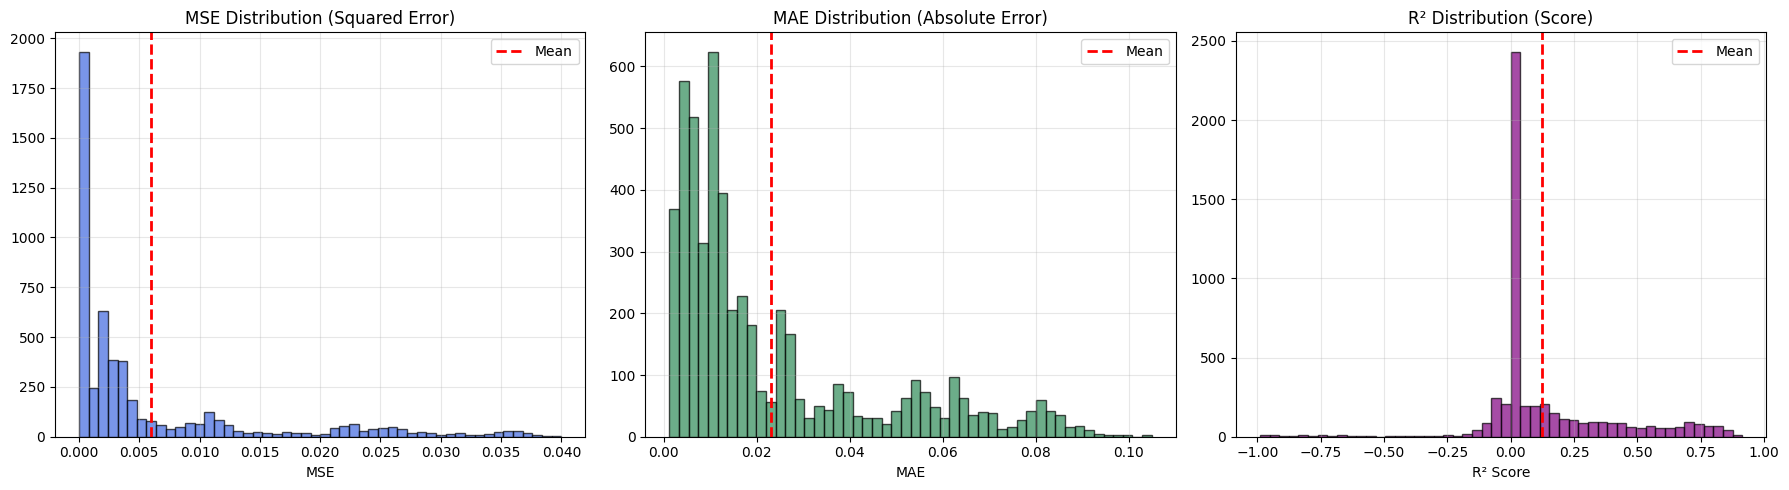

In [ ]:
# ===== VISUALIZE TEST METRICS DISTRIBUTION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram MSE
axes[0].hist(test_metrics['mse'], bins=50, color='royalblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(test_metrics['mse']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('MSE Distribution (Squared Error)')
axes[0].set_xlabel('MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram MAE
axes[1].hist(test_metrics['mae'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(test_metrics['mae']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_title('MAE Distribution (Absolute Error)')
axes[1].set_xlabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Histogram R²
axes[2].hist(test_metrics['r2'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].axvline(np.mean(test_metrics['r2']), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].set_title('R² Distribution (Score)')
axes[2].set_xlabel('R² Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. BEST VS WORST PREDICTIONS

🔴 Top 3 WORST predictions:
  1. Sample 1199: R²=-0.9901, MAE=0.0141
  2. Sample 2718: R²=-0.9856, MAE=0.0324
  3. Sample 2703: R²=-0.9790, MAE=0.0340

🟢 Top 3 BEST predictions:
  1. Sample 3589: R²=0.9137, MAE=0.0194
  2. Sample 3590: R²=0.9098, MAE=0.0206
  3. Sample 3602: R²=0.9043, MAE=0.0240


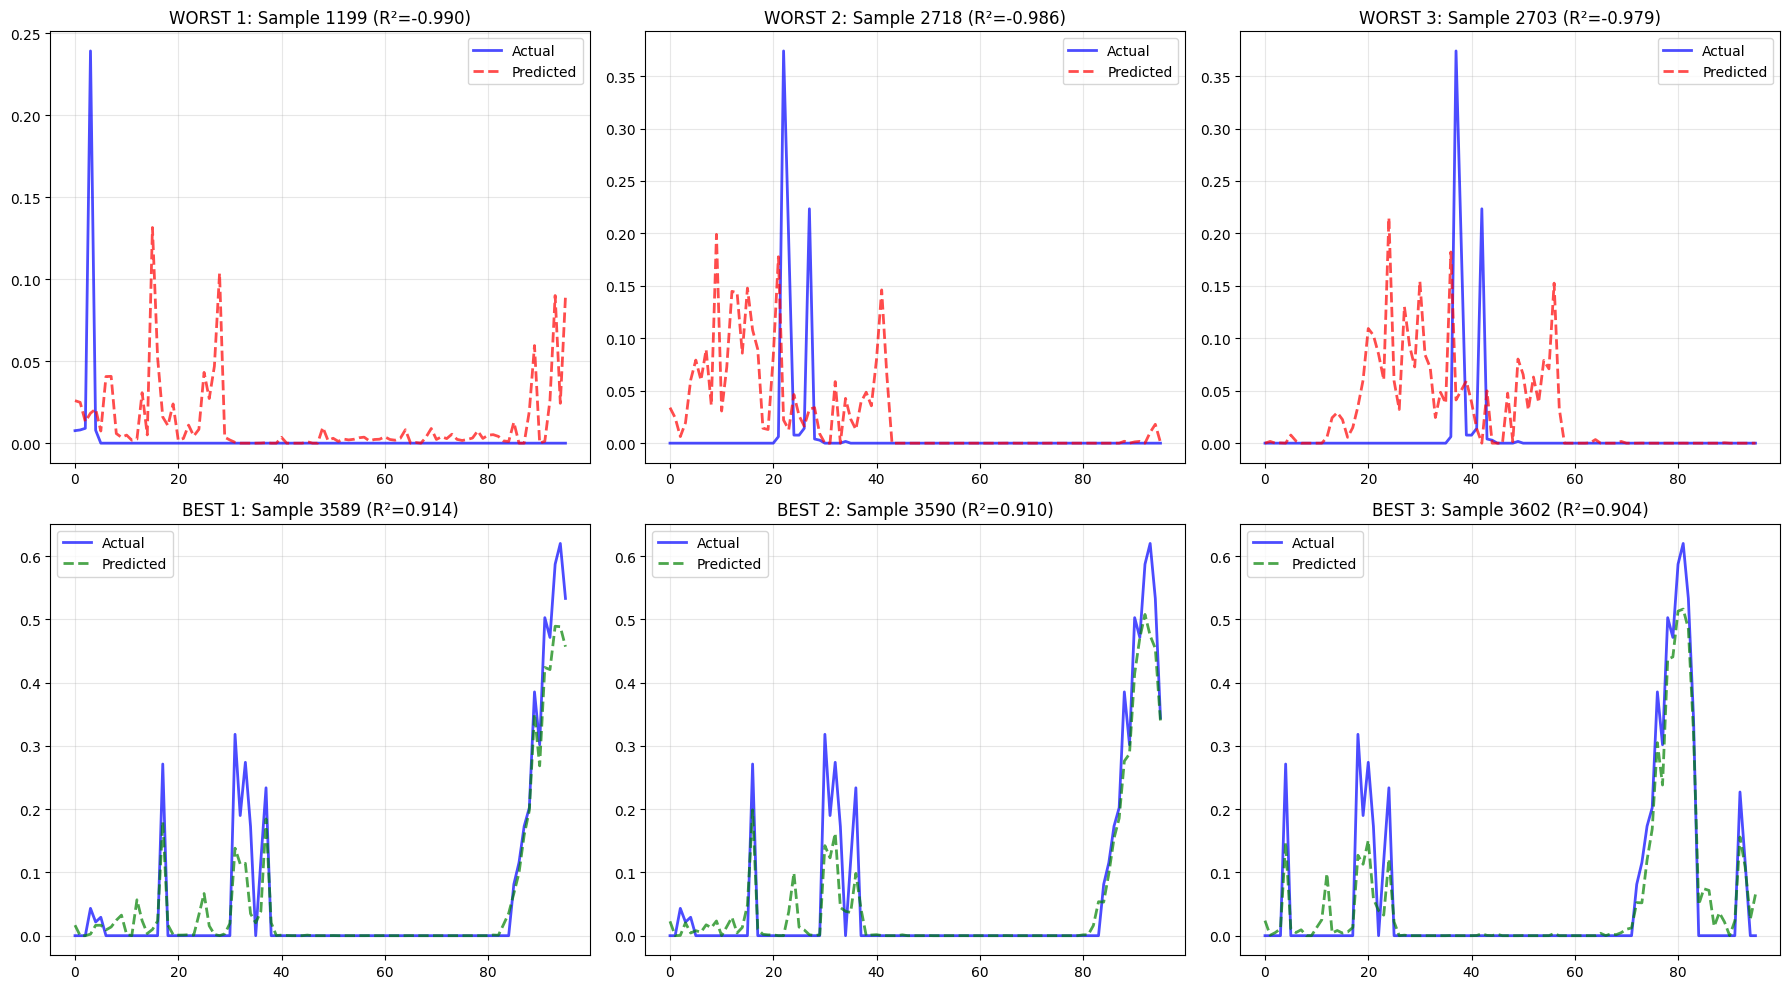

In [ ]:
# ===== BEST VS WORST PREDICTIONS VISUALIZATION =====
sorted_indices = np.argsort(test_metrics['r2'])
worst_3_idx = sorted_indices[:3]
best_3_idx = sorted_indices[-3:][::-1]

print("🔴 Top 3 WORST predictions:")
for rank, idx in enumerate(worst_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={test_metrics['r2'][idx]:.4f}, MAE={test_metrics['mae'][idx]:.4f}")

print("\n🟢 Top 3 BEST predictions:")
for rank, idx in enumerate(best_3_idx, 1):
    print(f"  {rank}. Sample {idx}: R²={test_metrics['r2'][idx]:.4f}, MAE={test_metrics['mae'][idx]:.4f}")

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, idx in enumerate(worst_3_idx):
    pred = y_test_pred[idx]
    actual = y_test_flat[idx]
    
    axes[0, i].plot(actual, label='Actual', color='blue', alpha=0.7, linewidth=2)
    axes[0, i].plot(pred, label='Predicted', color='red', linestyle='--', alpha=0.7, linewidth=2)
    axes[0, i].set_title(f'WORST {i+1}: Sample {idx} (R²={test_metrics["r2"][idx]:.3f})')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

for i, idx in enumerate(best_3_idx):
    pred = y_test_pred[idx]
    actual = y_test_flat[idx]
    
    axes[1, i].plot(actual, label='Actual', color='blue', alpha=0.7, linewidth=2)
    axes[1, i].plot(pred, label='Predicted', color='green', linestyle='--', alpha=0.7, linewidth=2)
    axes[1, i].set_title(f'BEST {i+1}: Sample {idx} (R²={test_metrics["r2"][idx]:.3f})')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. COMPARATIVE EVALUATION: TRAIN VS VAL VS TEST

In [ ]:
# ===== EVALUATION ON ALL 3 DATASETS =====
def evaluate_dataset(y_true_flat, y_pred_flat, dataset_name="Dataset"):
    """Evaluate predictions on a dataset"""
    # Flatten for aggregated metrics
    y_true_all = y_true_flat.flatten()
    y_pred_all = y_pred_flat.flatten()
    
    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)
    r2 = r2_score(y_true_all, y_pred_all)
    
    return {
        'dataset': dataset_name,
        'samples': len(y_true_flat),
        'mse': mse,
        'mae': mae,
        'r2': r2
    }

print("🔄 Evaluation in progress on Train, Validation and Test set...\n")

train_results = evaluate_dataset(y_train_flat, y_train_pred, "TRAIN")
val_results = evaluate_dataset(y_val_flat, y_val_pred, "VALIDATION")
test_results = evaluate_dataset(y_test_flat, y_test_pred, "TEST")

# Print comparison table
print("=" * 80)
print(f"{'Dataset':<15} {'Samples':>10} {'MSE':>15} {'MAE':>15} {'R²':>12}")
print("=" * 80)
for m in [train_results, val_results, test_results]:
    print(f"{m['dataset']:<15} {m['samples']:>10,} {m['mse']:>15.6f} {m['mae']:>15.6f} {m['r2']:>12.4f}")
print("=" * 80)

# Calculate overfitting gap
train_test_gap = train_results['r2'] - test_results['r2']
val_test_gap = val_results['r2'] - test_results['r2']

print(f"\n📈 Overfitting Analysis:")
print(f"  Train-Test R² Gap: {train_test_gap:+.4f} {'⚠️ OVERFITTING' if train_test_gap > 0.1 else '✅ OK'}")
print(f"  Val-Test R² Gap:   {val_test_gap:+.4f} {'⚠️ LEAKAGE' if abs(val_test_gap) > 0.05 else '✅ OK'}")

🔄 Evaluation in progress on Train, Validation and Test set...

Dataset            Samples             MSE             MAE           R²
TRAIN               24,097        0.001126        0.009318       0.8423
VALIDATION           5,377        0.006258        0.023640       0.4610
TEST                 5,281        0.006011        0.023000       0.2799

📈 Overfitting Analysis:
  Train-Test R² Gap: +0.5624 ⚠️ OVERFITTING
  Val-Test R² Gap:   +0.1811 ⚠️ LEAKAGE


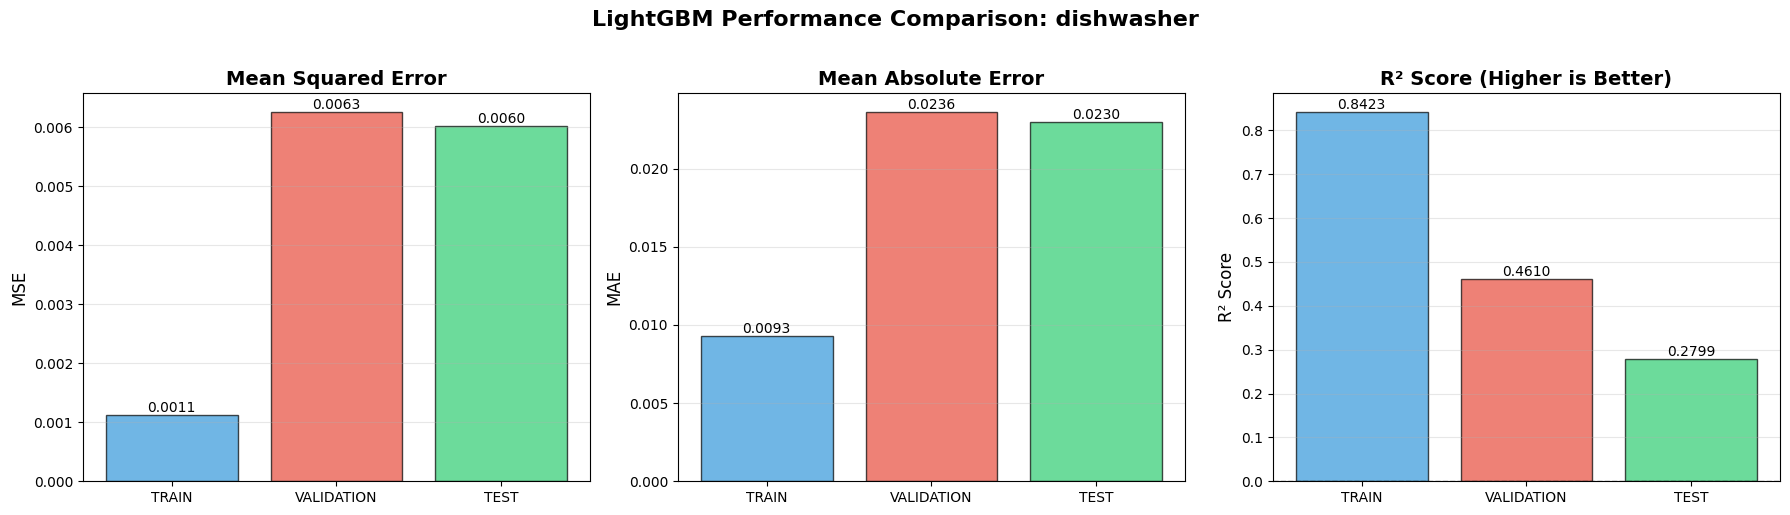


💡 Interpretation:
  🚨 Significant overfitting - Increase regularization!
  🚨 Very low performance - review approach


In [ ]:
# ===== COMPARATIVE VISUALIZATION =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_results = [train_results, val_results, test_results]
colors = ['#3498db', '#e74c3c', '#2ecc71']
dataset_names = ['TRAIN', 'VALIDATION', 'TEST']

# Plot 1: MSE Comparison
mse_values = [m['mse'] for m in datasets_results]
bars1 = axes[0].bar(dataset_names, mse_values, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, mse_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 2: MAE Comparison
mae_values = [m['mae'] for m in datasets_results]
bars2 = axes[1].bar(dataset_names, mae_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, mae_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 3: R² Comparison
r2_values = [m['r2'] for m in datasets_results]
bars3 = axes[2].bar(dataset_names, r2_values, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[2].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{val:.4f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=10)

plt.suptitle(f'LightGBM Performance Comparison: All Appliances', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Results interpretation
print("\n💡 Interpretation:")
if train_test_gap < 0.05:
    print("  ✅ Model generalizes well - Train and Test similar")
elif train_test_gap < 0.15:
    print("  ⚠️ Slight overfitting - Train better than Test")
else:
    print("  🚨 Significant overfitting - Increase regularization!")

if test_results['r2'] > 0.7:
    print("  🎯 Excellent performance on test set!")
elif test_results['r2'] > 0.5:
    print("  📊 Acceptable performance on test set")
elif test_results['r2'] > 0.3:
    print("  ⚠️ Low performance - consider architecture improvements")
else:
    print("  🚨 Very low performance - review approach")

## 11. FEATURE IMPORTANCE (OPTIONAL)

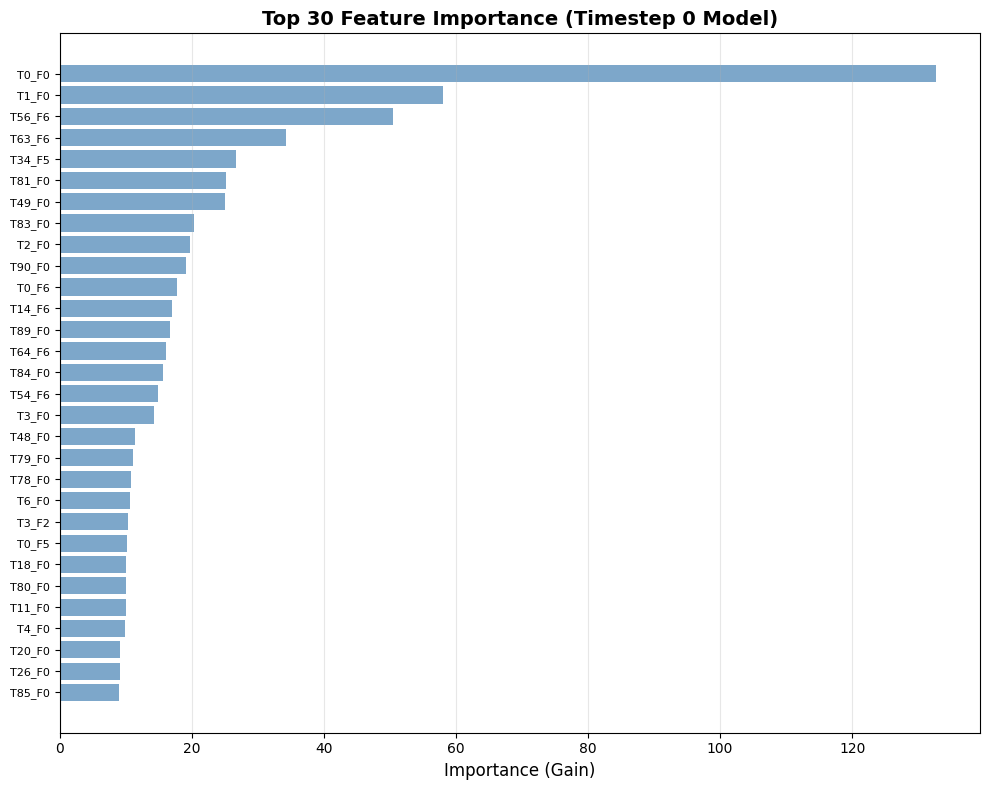


📊 Feature naming: T = Timestep in input window, F = Feature index
   Example: T50_F0 = Timestep 50, Feature 0 (likely aggregate consumption)


In [ ]:
# ===== FEATURE IMPORTANCE ANALYSIS =====
# Get feature importance from first model (timestep 0)
# This gives insight into which input features are most important

feature_importance = models[0].feature_importance(importance_type='gain')
feature_names = [f'T{t//num_input_features}_F{t%num_input_features}' for t in range(len(feature_importance))]

# Get top 30 most important features
top_n = 30
sorted_idx = np.argsort(feature_importance)[-top_n:]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), feature_importance[sorted_idx], color='steelblue', alpha=0.7)
plt.yticks(range(top_n), [feature_names[i] for i in sorted_idx], fontsize=8)
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title(f'Top {top_n} Feature Importance (Timestep 0 Model)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n📊 Feature naming: T = Timestep in input window, F = Feature index")
print(f"   Example: T50_F0 = Timestep 50, Feature 0 (likely aggregate consumption)")